###### Based on tutorials available at:
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html <br>
https://deeplizard.com/learn/video/FU-sNVew9ZA 

##### Import required modules and functions

In [1]:
import gym  # provides the CartPole learning environment
import math
import random
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim  # optimisation algorithms and backprop functions
import torch.nn.functional as F  # neuron activation functions
import torchvision.transforms as T  # used to transform and process screen images

from collections import namedtuple  # experience tuples will be stored with an assigned name field
from itertools import count  # iterator which requires a break condition to terminate, useful if unknown number of iteration steps required
from PIL import Image  # Python Imaging Library

is_ipyn = 'inline' in mpl.get_backend()  # mpl plots are displayed inline, this assigns 'true' boolean to parameter 'is_ipyn'
if is_ipyn: from IPython import display  # clear_output() function of module 'display' will be used to update plots

##### Deep Q-Network 

In [2]:
class DQN(nn.Module):
    def __init__(self, h, w):  # <h,w> --> <height,width> of input image 
        super().__init__()
        self.fc1 = nn.Linear(in_features=3*h*w, out_features=24)  # fully connected layer with input weights for RGB images of size h*w   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)  # output layer will provide Q-values for the two available actions: left/right
        
    def forward(self, t):  # flatten and then forward propagate input tensor 't' through the network
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))  # weighted inputs are passed to nodes with a Rectified Linear Unit (ReLU) activation function
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

##### Replay Memory Buffer 

In [3]:
ex = namedtuple(  # experience / transition / 'sars' tuple
    'experience', 
    ('state', 'action', 'reward', 'next_state')
)


class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity  # buffer capacity
        self.memory = []
        self.push_count = 0
    
    def push(self, experience):  # push an experience tuple to the buffer
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience  # old experiences are eventually overwritten
        self.push_count += 1
    
    def can_sample(self, batch_size):
        # returns boolean, call to check if memory has accummulated sufficient experience tuples to sample a batch
        return len(self.memory) >= batch_size
        
    def sample(self, batch_size):  # select a random batch of experiences from the buffer
        return random.sample(self.memory, batch_size)

##### Agent / Learner 

In [4]:
class EpsGreedyStrat():  # used to construct an epsilon-greedy strategy object for the agent
    def __init__(self, initial, final, decay):
        self.initial = initial
        self.final = final
        self.decay = decay
    
    def get_current_rate(self, current_step):
        return self.final + (self.initial - self.final) * math.exp(-1. * current_step * self.decay)  # epsilon decay schedule
    

class Agent():
    def __init__(self, strat, num_actions, device):
        self.device = device  # user may specify which processor (CPU/GPU) the agent should pass tensor computations to
        self.strat = strat  # a strategy object must have been created using the 'EpsGreedyStat' class
        self.num_actions = num_actions
        self.current_step = 0
        
    def select_action(self, state, policy_net):
        rate = self.strat.get_current_rate(self.current_step)
        self.current_step += 1
        if rate > random.random():
            action = random.randrange(self.num_actions)  # explore, select next action randomly
            return torch.tensor([action]).to(self.device)  # convert chosen action to a torch tensor and pass to specified processor  
        else:
            # network passes used for inference (action selection) do not contribute to gradient descent computations
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)  # exploit, select next action to maximise Q(s,a) 

##### Environment Manager 

In [5]:
class EnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v1').unwrapped  # create a CartPole environment using the gym toolkit
        self.env.reset()  # reset the environment before an initial observation can be made
        self.current_screen = None  # at the start of an episode there are no observations to display
        self.done = False  # boolean flag to check whether an episode has terminated
        
    
    ## wrapper functions, methods within the gym environment can be called using an 'EnvManager' object instead
    def reset(self):  # initalise environment to the starting state
        self.env.reset()
        self.current_screen = None
    
    def render(self, mode='human'):  # render the current environment state to the screen, default is a 'human-friendly' image 
        return self.env.render(mode)

    def close(self):  # close the environment once agent has finished
        self.env.close()
        
        
    ## screen processing
    def crop(self, screen):
        height = screen.shape[1]  # screen dimensions are (Channels,Height,Width)
        screen = screen[:, int(height * 0.4):int(height * 0.8), :]  # upper 40% and lower 20% of screen are cropped
        return screen

    def transform(self, screen):       
        # convert screen data to floats, rescale RGB values to range [0,1], convert to torch tensor
        screen = torch.from_numpy(np.ascontiguousarray(screen, dtype=np.float32) / 255)
        # define a composite image transformation using 'torchvision' package
        resize = T.Compose([ T.ToPILImage(), T.Resize((40,90)), T.ToTensor() ])  # number of network inputs = 3*40*90
        return resize(screen).unsqueeze(0).to(self.device)  # insert a 'batch' dimension (CHW --> BCHW)

    def process(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects image dimensions CHW, transpose from HWC
        screen = self.crop(screen)
        return self.transform(screen)

    def get_screen_height(self):
        screen = self.process()
        return screen.shape[2]  # after process()ing, screen has dimensions BCHW

    def get_screen_width(self):
        screen = self.process()
        return screen.shape[3]
    
    
    ## define current state to be the difference between successive screens (rendered as numerical RGB arrays)
    def get_state(self):
        if self.current_screen is None or self.done:
            self.current_screen = self.process()
            black_screen = torch.zeros_like(self.current_screen)  # inital and terminal states are represented with a zero-populated RGB array
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.process()
            self.current_screen = s2
            return s2 - s1
        
        
    ## methods to visualise performance data
    def get_moving_average(self, period, values):
        # 'values' will accept a numpy array of total elapsed timesteps within each episode, equal to total reward earned within
        # the episode (for the CartPole environment). 'period' is the period for the moving average: how many episodes to average over.
        values = torch.tensor(values, dtype=torch.float)
        if len(values) >= period:  # if number of terminated episodes >= specified period
            # the tensor of rewards is divided into slices of length='period', each slice is averaged, then the tensor is flattened
            moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
            moving_avg = torch.cat((torch.zeros(period-1), moving_avg))   # the first (period-1) elements of the moving average are zero
            return moving_avg.numpy()
        else:  # if insufficient number of episodes have terminated, return a tensor of zeros
            moving_avg = torch.zeros(len(values))
            return moving_avg.numpy()
        
    def make_plot(self, values, moving_avg_period):
        plt.figure(2, figsize=[7.2, 5])  # default [6.4, 4.8]
        plt.clf()  # clear the figure        
        plt.title('Agent Performance')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward Earned')
        plt.plot(values)  # plot the rewards (= number of timesteps) of each episode
        mAvg = self.get_moving_average(moving_avg_period, values)
        plt.plot(mAvg)  # plot the moving average of the rewards    
        plt.pause(0.001)  # pause processor computations for one millisecond
        #print("Episode", len(values),":","\n", moving_avg_period, "episode moving avg =", mAvg[-1])
        if is_ipyn: display.clear_output(wait=True)  # wait to clear the output until new output is available to replace it
    
    
    ## action methods
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        # passing an action to step() executes it within the environment and returns a feedback tuple: 
        # <observation, immediate reward, boolean flag for episode termination, diagnostic info>
        return torch.tensor([reward], device=self.device)

##### Data Manipulation 

In [6]:
## returns a tuple of torch tensors, each tensor contains a sequential list of either all inital states, all actions, all immediate rewards, 
## or all successor states that comprise the batch sample of the memory buffer
def extract_tensors(experiences):  # argument is a batch of named tuples of torch tensors
    # 'tup' is a named tuple of torch tensor batches, the "inverse" of 'experiences' (see https://stackoverflow.com/a/19343/3343043)
    tup = ex(*zip(*experiences))
    # the batches of tensors within each element of the named tuple 'tup' are concatenated into a single tensor, separately for each element
    t1 = torch.cat(tup.state)
    t2 = torch.cat(tup.action)
    t3 = torch.cat(tup.reward)
    t4 = torch.cat(tup.next_state)
    return (t1,t2,t3,t4)  # the four resulting torch tensors are packaged into a tuple



## static methods of this class are called to compute Q-values using the two neural networks
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    ## returns a tensor of Q-values from the policy network, one for each sampled state-action pair  
    @staticmethod
    def get_current(policy_net, states, actions):
        # policy_net(states) returns a tensor list of Q-value pairs for each state, gather() selects from each pair the Q-value 
        # corresponding to the action taken from the state within that particular experience tuple
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    ## returns a tensor of maximum Q-values from the target network, one for each sampled successor state
    @staticmethod        
    def get_next(target_net, next_states):
        # terminal states are represented by a zero-populated RGB array, so a boolean mask to index terminal successor states
        # can be constructed by finding states within 'next_states' without non-zero elements 
        terminal_state_mask = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_terminal_states = next_states[~terminal_state_mask]  # non-terminal states are indexed by the negated mask
        # terminal states are defined to have Q=0, so initialise a tensor of zeros equal in length to the 'next_states' tensor...
        values = torch.zeros(next_states.shape[0]).to(QValues.device)
        # ...then use the negated mask as an index array to insert the max Q-values for each non-terminal successor state
        values[~terminal_state_mask] = target_net(non_terminal_states).max(dim=1)[0].detach()
        return values

##### Initialisation and construction 

In [ ]:
## initialise hyperparameters
episodes = 400 # e.g. 1000
moving_avg_period = 100  # not technically an optimisable hyperparameter, but initialised here for convenience
buffer_capacity = 100000  # experience capacity of the replay memory
batch_size = 100  # sampling size for experience replay

eps_initial = 1  # initial value for the exploration parameter of the epsilon-greedy strategy 
eps_final = 0.01
eps_decay = 0.002 # e.g. 0.001

gamma = 0.99  # discount factor in TD error e.g. 0.999
lr = 0.004  # learning rate for incremental updates to policy network parameters e.g. 0.001
target_sync = 10  # completed episodes between each sync of network parameters e.g. 10


## construct objects
# environment manager
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise default to CPU
em = EnvManager(device)

# agent
strat = EpsGreedyStrat(eps_initial, eps_final, eps_decay)
agent = Agent(strat, em.num_actions_available(), device)

# replay memory
memory = ReplayMemory(buffer_capacity)

# neural networks
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)  # policy network weights to be optimised using ADAM algorithm, betas=(0.9,0.999)

target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())  # target network weights are cloned from policy network
target_net.eval()  # target network is used only to evaluate, its parameters are frozen (but are periodically synced)

##### Learning and Visualisation 

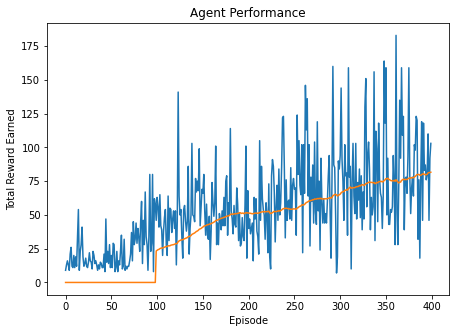

In [8]:
episode_durations = []
for episode in range(episodes):
    em.reset()
    state = em.get_state()  # identify current state
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(ex(state, action, reward, next_state))  # push transition tuple to the buffer
        state = next_state
        
        if memory.can_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_Q_values = QValues.get_current(policy_net, states, actions)  # torch.tensor([ [val],[val],[val]... ])
            next_Q_values = QValues.get_next(target_net, next_states)
            target_Q_values = rewards + (gamma * next_Q_values)  # torch.tensor([ val,val,val... ])

            loss = F.mse_loss(current_Q_values, target_Q_values.unsqueeze(1))  # mean squared error loss, by default returns mean loss of the batch 
            optimizer.zero_grad()  # by default PyTorch accummulates parameter gradients over multiple back passes, this resets them to zero instead 
            loss.backward()  # backpropagation: computes the gradients x.grad = d/dx(loss) for each policy network parameter x
            optimizer.step()  # updates the policy network parameters: x += -lr * x.grad
            
        if em.done:
            episode_durations.append(timestep)  # number of timesteps = total reward
            em.make_plot(episode_durations, moving_avg_period)
            break
            
    if episode % target_sync == 0:  # if sync due, update target network parameters by cloning latest policy network parameters  
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()